# Sample Simulation: Talk of the Town

This notebook contains a reimplementation of the Talk of the town simulation in Neighborly. You can find the originial Talk of the Town implementation [here](https://github.com/james-owen-ryan/talktown).

It simulates a single town and characters engage in generally mundane behavior such as being born, growing up, going to school, working jobs, finding romance, and having families. Since Talk of the Town's content comes bundled with neighborly, we don't need to define any additional content within this notebook.

In [ ]:
from __future__ import annotations

import time
import math
from typing import Dict, Any

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from neighborly.config import NeighborlyConfig
from neighborly.simulation import Neighborly
from neighborly.core.ecs import World, Active, ISystem
from neighborly.core.time import HOURS_PER_YEAR
from neighborly.data_collection import DataCollector
from neighborly.components.character import GameCharacter
from neighborly.core.time import SimDateTime

The following are utility functions and data tracking systems to the simulatio

In [4]:
def run_sim_for(sim: Neighborly, years: int) -> None:
    """Run the simulation for a given number of years and display a progrss bar.

    Parameters
    ----------
    sim
        A Neighborly simulation instance.
    years
        The number of years to simulate.
    """

    # tqdm requires needs to know the number of iterations beforehand.
    # So, we need to calculate how many timesteps are in the given number
    # of years (rounding up to the nearest whole number)
    total_timesteps = math.ceil(
        float(years * HOURS_PER_YEAR) / sim.config.time_increment.total_hours
    )

    for _ in tqdm(range(total_timesteps)):
        sim.step()

## Tracking Population Size

A simple system to create is one that tracks the population size each year. We define it as an ECS system that runs during the early-update phase of a simulation step and counts the number of active characters in the simulation

In [ ]:
data_collector.create_new_table("population", ("timestamp", "population"))


class TrackPopulation(ISystem):
    sys_group = "early-update"
    priority = 9999

    last_recorded_year = 0

    def process(self, *args, **kwargs):
        dc = self.world.get_resource(DataCollector)
        current_date = self.world.get_resource(SimDateTime)

        if current_date.year > self.last_recorded_year:
            population = len(self.world.get_components((Active, GameCharacter)))
            dc.add_table_row(
                "population", {"timestamp": current_date.year, "population": population}
            )
            self.last_recorded_year = current_date.year

In [23]:
sim = Neighborly(
    NeighborlyConfig.parse_obj(
        {
            "seed": "Apples",
            "time_increment": "1mo",
            "verbose": False,
            "relationship_schema": {
                "components": {
                    "Friendship": {
                        "min_value": -100,
                        "max_value": 100,
                    },
                    "Romance": {
                        "min_value": -100,
                        "max_value": 100,
                    },
                    "InteractionScore": {
                        "min_value": -5,
                        "max_value": 5,
                    },
                }
            },
            "plugins": [
                "neighborly.plugins.defaults.all",
                "neighborly.plugins.talktown.spawn_tables",
                "neighborly.plugins.talktown",
            ],
        }
    )
)


data_collector = sim.world.get_resource(DataCollector)


sim.world.add_system(TrackPopulation())


run_sim_for(sim, 500)

  0%|          | 0/6000 [00:00<?, ?it/s]

## Data visualization

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Text(0.5, 1.0, 'Population of Simulation (seed: Apples)')

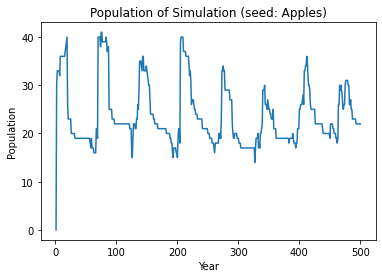

In [28]:
plt.plot(
    data_collector.tables["population"]["timestamp"],
    data_collector.tables["population"]["population"],
)
plt.xlabel("Year")
plt.ylabel("Population")
plt.title(f"Population of Simulation (seed: {sim.config.seed})")